## Obenhaus et al. - Fig.4 Cellmap examples and Fig.S5A

Example code to generate cell maps as shown in 
- Figure 4A and 
- Figure S5A


In [2]:
# Set up basics
import sys, os
import numpy as np 
import pandas as pd
import datajoint as dj
from IPython.display import display

In [3]:
 sys.path.append('..')
from dj_schemas.utils import *

Connecting horsto@kavlidatajoint02.it.ntnu.no:3306


In [4]:
# Make plots pretty 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'

In [5]:
# To prevent bug in figure export as pdf: 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from mpl_toolkits.axes_grid1 import make_axes_locatable
def now():
    # New time every minute
    return datetime.strftime(datetime.now(),'%d_%m_%Y %H_%M')

In [6]:
# Standard figure export directory:
figure_dir = '../YOUR_EXPORT_DIRECTORY/'

### Filter sessions / cells

In [7]:
from helpers_topography.plotting_helpers import *
from dj_plotter.helpers.plotting_helpers import make_linear_colormap
from dj_plotter.plotter import dj_plotter
import cmasher as cmr

### Show some nice ROI maps with Grid, Border and HD cells, another one for OV cells

In [8]:
# Example 87187: 7335f71312003bbe (2019-09-17 18:29:37))
# Example 88106: 7bc761d3dc5dcae1 (2019-09-19 15:43:50)
# Example 87245: 79cf52ce2fd423a6

In [9]:
session_name = "79cf52ce2fd423a6"
filtered_cells = FilteredCells & f'session_name = "{session_name}"'
Session & f'session_name = "{session_name}"'

metasession_name Meta session name (hash),session_order Order of session within meta sessions (zero index!),"session_name Session name: Hash of animal_id, datasource_id, timestamp and combined 'yes'/'no' label",animal_id,datasource_id,animal_name Animal name in mlims,timestamp,combined,timeseries_name Timeseries name [e.g. MUnit_0],experiment_type,username NTNU username
5e79f22f56550213,0,79cf52ce2fd423a6,78d55f99715f7b87,0,87245,2019-08-26 17:47:40,yes,87245-openfield,2Pminiscope_A,horsto


In [10]:
# Cell parameter dictionary
parameter_dict_cell = (FilteredCellsParams & 'param_hash_id_cell = "standard"').fetch1('parameter_dict_cell')

# MEC cells
cells = Session * RoisCorr * ProjectionCorr * filtered_cells.proj() & parameter_dict_cell & RoisCorrBrainLoc.MEC
len(cells)

322

In [11]:
from colorutils import Color, ArithmeticModel

In [12]:
pure_only = True

In [13]:
# Cell type filters
bordercells95 = BorderScore * CutoffsBorderScore.proj('borderscore_95') & 'borderscore > borderscore_95'
gridcells95   = GridScore * CutoffsGridscore.proj('gridscore_95') & 'gridscore > gridscore_95'
hdcells95     = AngularRate.Stats * CutoffsMVL.proj('mvl_95') & 'mvl > mvl_95'
ovcells       = OVC.proj(is_ovc='is_ovc', session_name='base_session') & 'is_ovc > 0.5'

In [14]:
if pure_only:
    border_cells  = (bordercells95 - gridcells95 - hdcells95 - ovcells)  & cells & parameter_dict_cell
    grid_cells    = (gridcells95 - bordercells95 - hdcells95 - ovcells)  & cells & parameter_dict_cell
    hd_cells      = (hdcells95 - bordercells95 - gridcells95 - ovcells)  & cells & parameter_dict_cell
    ov_cells      = (ovcells - bordercells95 - gridcells95 - hdcells95)  & cells & parameter_dict_cell
    print('Only pure cell types')
else: 
    border_cells  = bordercells95 & cells & parameter_dict_cell
    grid_cells    = gridcells95 & cells & parameter_dict_cell
    hd_cells      = hdcells95 & cells & parameter_dict_cell
    ov_cells      = ovcells  & cells & parameter_dict_cell
    print('Conjunctive cells included')

Only pure cell types


In [15]:
len(border_cells), len(grid_cells), len(hd_cells), len(ov_cells)

(14, 6, 28, 31)

In [18]:
# Create colormap
c_cell_types = make_linear_colormap(np.arange(4), cmap='Set2')
availabel_colors = {}
for no, celltype in enumerate(['border','grid','hd','ov']):
    availabel_colors[celltype] = c_cell_types[no]

In [19]:
# Add "type" and color info for each cell in each list 

colors = []
for cell in cells:
    if border_cells & cell:
        colors.append(availabel_colors['border'])
    elif grid_cells & cell:
        colors.append(availabel_colors['grid'])
    elif hd_cells & cell: 
        colors.append(availabel_colors['hd']) 
    elif ov_cells & cell: 
        colors.append(availabel_colors['ov']) 
    elif (bordercells95 & cell) \
            or (gridcells95 & cell) \
            or (hdcells95 & cell) \
            or (ovcells & cell):
        colors.append(np.array([.68,.68,.68]))
    else: 
        colors.append(np.array([.9,.9,.9]))

In [20]:
len(colors)

322

Drawing ROIs:   0%|          | 0/322 [00:00<?, ?it/s]

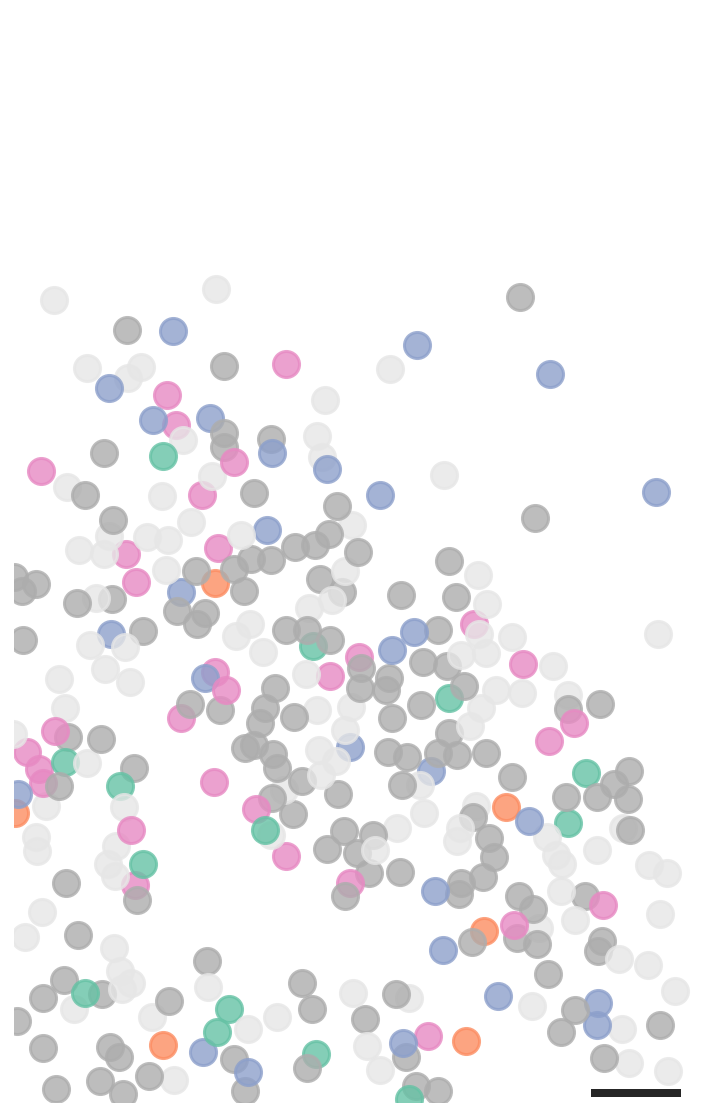

In [21]:
plot = dj_plotter(cells)
plot.rois(draw_image=False, draw_pixels=False, colors=colors,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

In [24]:
from colorutils import Color

In [25]:
for classname, color in availabel_colors.items():
    print(classname)
    display(Color(tuple(color*255)))

border


<Color (101.99999999999994, 194.00000000000003, 165.00000000000003)>

grid


<Color (252.0, 141.0, 97.99999999999999)>

hd


<Color (141.00000000000006, 160.00000000000003, 202.99999999999997)>

ov


<Color (230.99999999999997, 138.00000000000003, 195.0)>

### Create separate maps for each cell type and <br>export both conjunctive and non-conjunctive

Drawing ROIs:   0%|          | 0/322 [00:00<?, ?it/s]

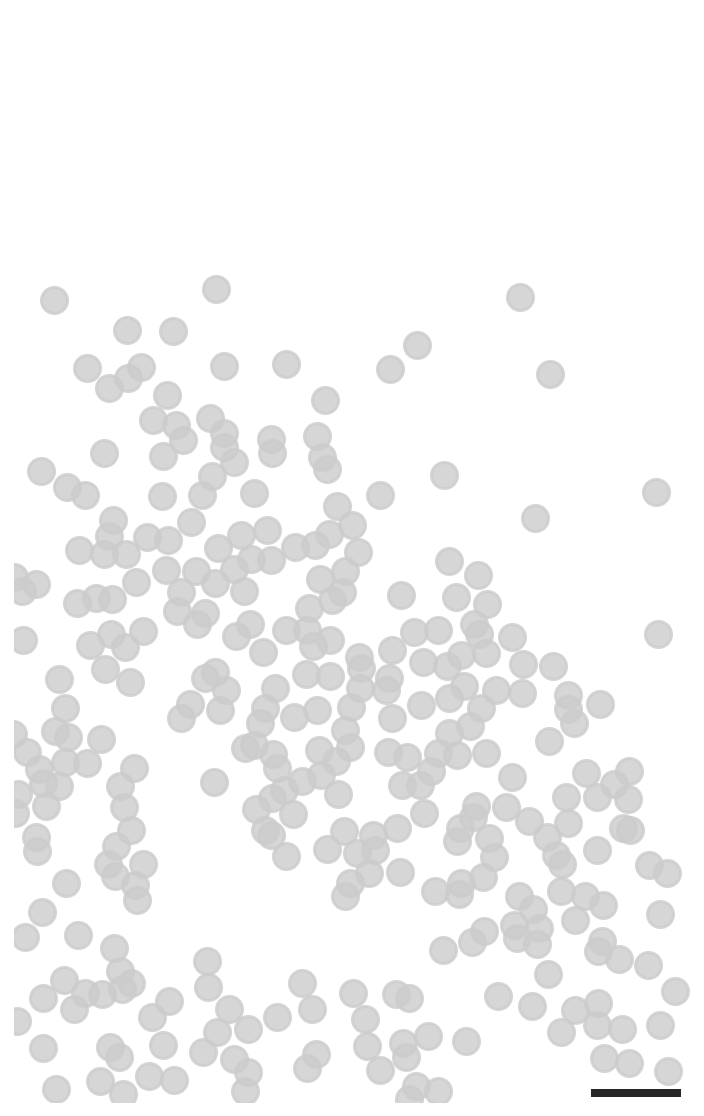

In [22]:
#All cells in grey
plot = dj_plotter(cells)
plot.rois(draw_image=False, draw_pixels=False, colors=[[.8,.8,.8]] * len(cells),
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

### Grid x HD 

In [23]:
filtered_grid = gridcells95 & cells & parameter_dict_cell
filtered_hd   = hdcells95 & cells & parameter_dict_cell

In [24]:
filtered_cells = cells & [filtered_grid, filtered_hd]

In [25]:
# Add "type" and color info for each cell in each list 
colors = []
for cell in tqdm(filtered_cells, total=len(filtered_cells)):
    if (filtered_grid & cell) and (filtered_hd & cell):
        colors.append(np.array([.8,.8,.8]))
    elif filtered_grid & cell:
        colors.append(availabel_colors['grid'])
    elif filtered_hd & cell: 
        colors.append(availabel_colors['hd']) 

100%|██████████| 66/66 [00:46<00:00,  1.43it/s]


Drawing ROIs:   0%|          | 0/66 [00:00<?, ?it/s]

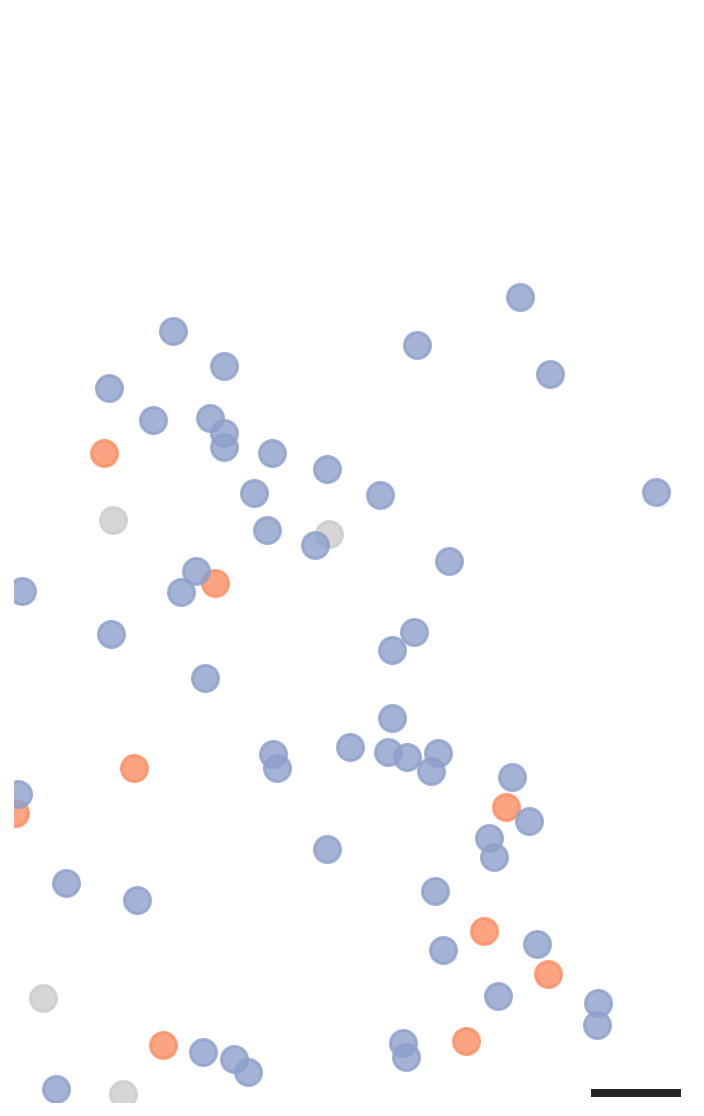

In [26]:
plot = dj_plotter(filtered_cells)
plot.rois(draw_image=False, draw_pixels=False, colors=colors,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

In [27]:
len(colors)

66

### Grid x OV

In [28]:
filtered_grid = gridcells95 & cells & parameter_dict_cell
filtered_ov   = ovcells & cells & parameter_dict_cell

In [29]:
filtered_cells = cells & [filtered_grid, filtered_ov]

In [30]:
# Add "type" and color info for each cell in each list 
colors = []
for cell in tqdm(filtered_cells, total=len(filtered_cells)):
    if (filtered_grid & cell) and (filtered_ov & cell):
        colors.append(np.array([.8,.8,.8]))
    elif filtered_grid & cell:
        colors.append(availabel_colors['grid'])
    elif filtered_ov & cell: 
        colors.append(availabel_colors['ov']) 

100%|██████████| 54/54 [00:44<00:00,  1.21it/s]


Drawing ROIs:   0%|          | 0/54 [00:00<?, ?it/s]

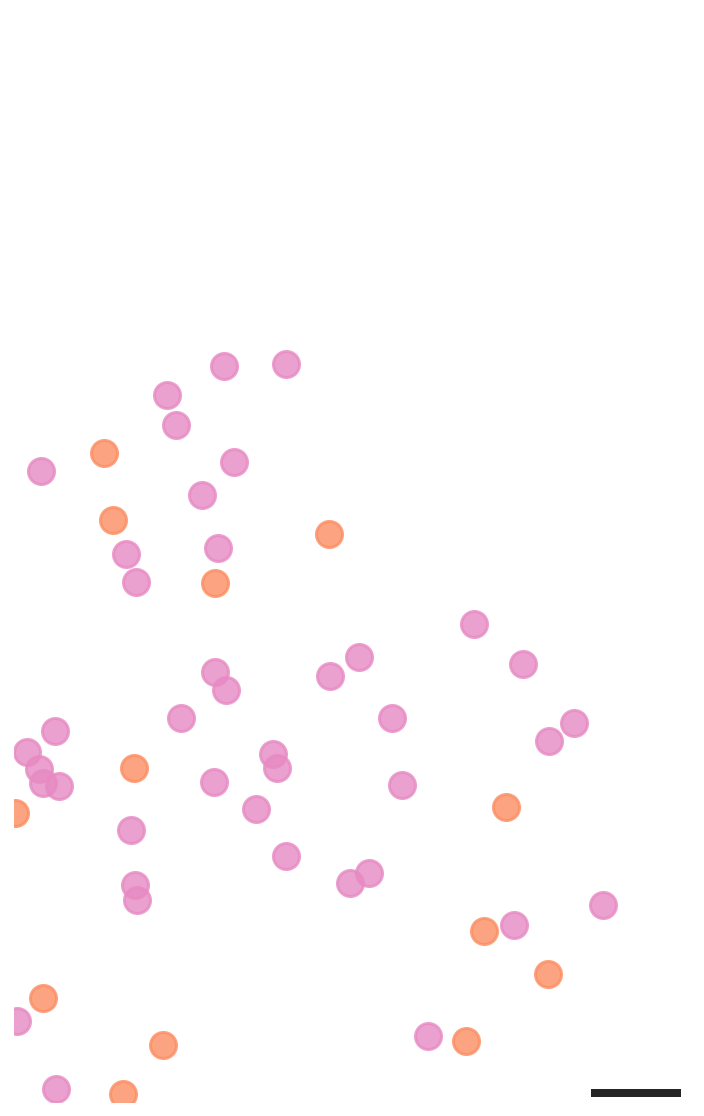

In [31]:
plot = dj_plotter(filtered_cells)
plot.rois(draw_image=False, draw_pixels=False, colors=colors,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

### Grid x Border

In [32]:
filtered_grid     = gridcells95 & cells & parameter_dict_cell
filtered_border   = bordercells95 & cells & parameter_dict_cell

In [33]:
filtered_cells = cells & [filtered_grid, filtered_border]

In [34]:
# Add "type" and color info for each cell in each list 
colors = []
for cell in tqdm(filtered_cells, total=len(filtered_cells)):
    if (filtered_grid & cell) and (filtered_border & cell):
        colors.append(np.array([.8,.8,.8]))
    elif filtered_grid & cell:
        colors.append(availabel_colors['grid'])
    elif filtered_border & cell: 
        colors.append(availabel_colors['border']) 

100%|██████████| 42/42 [00:32<00:00,  1.31it/s]


Drawing ROIs:   0%|          | 0/42 [00:00<?, ?it/s]

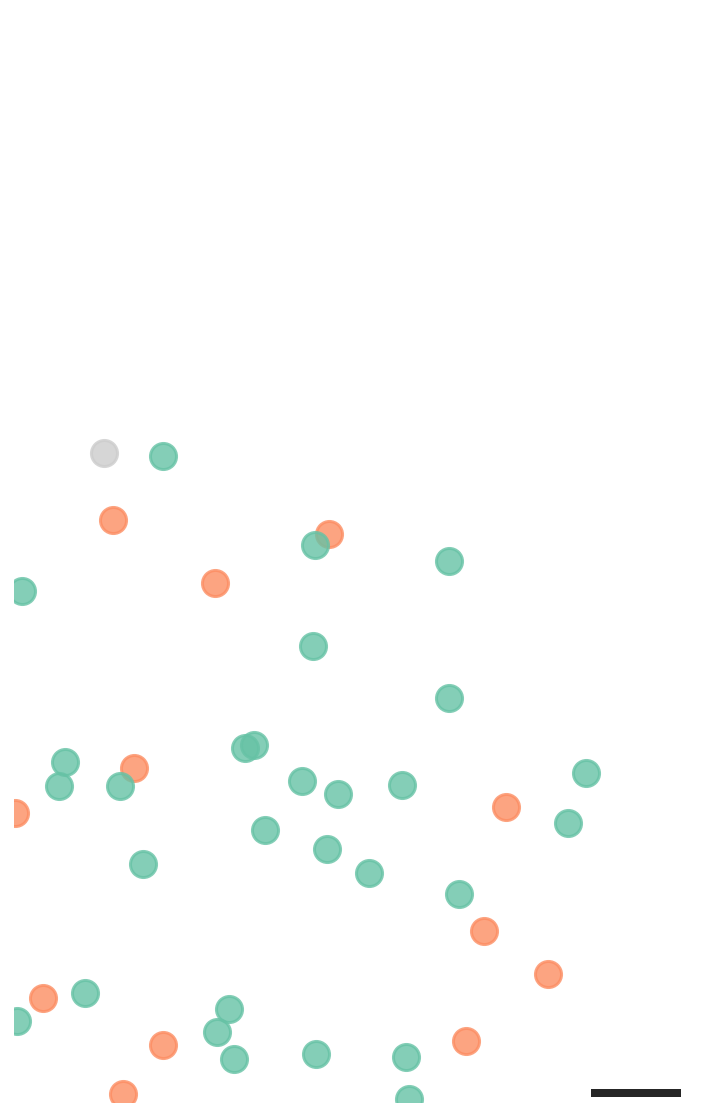

In [35]:
plot = dj_plotter(filtered_cells)
plot.rois(draw_image=False, draw_pixels=False, colors=colors,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

### HD x OV

In [36]:
filtered_hd   = hdcells95 & cells & parameter_dict_cell
filtered_ov   = ovcells & cells & parameter_dict_cell

In [37]:
filtered_cells = cells & [filtered_hd, filtered_ov]

In [38]:
# Add "type" and color info for each cell in each list 
colors = []
for cell in tqdm(filtered_cells, total=len(filtered_cells)):
    if (filtered_hd & cell) and (filtered_ov & cell):
        colors.append(np.array([.8,.8,.8]))
    elif filtered_hd & cell:
        colors.append(availabel_colors['hd'])
    elif filtered_ov & cell: 
        colors.append(availabel_colors['ov']) 

100%|██████████| 92/92 [01:06<00:00,  1.39it/s]


Drawing ROIs:   0%|          | 0/92 [00:00<?, ?it/s]

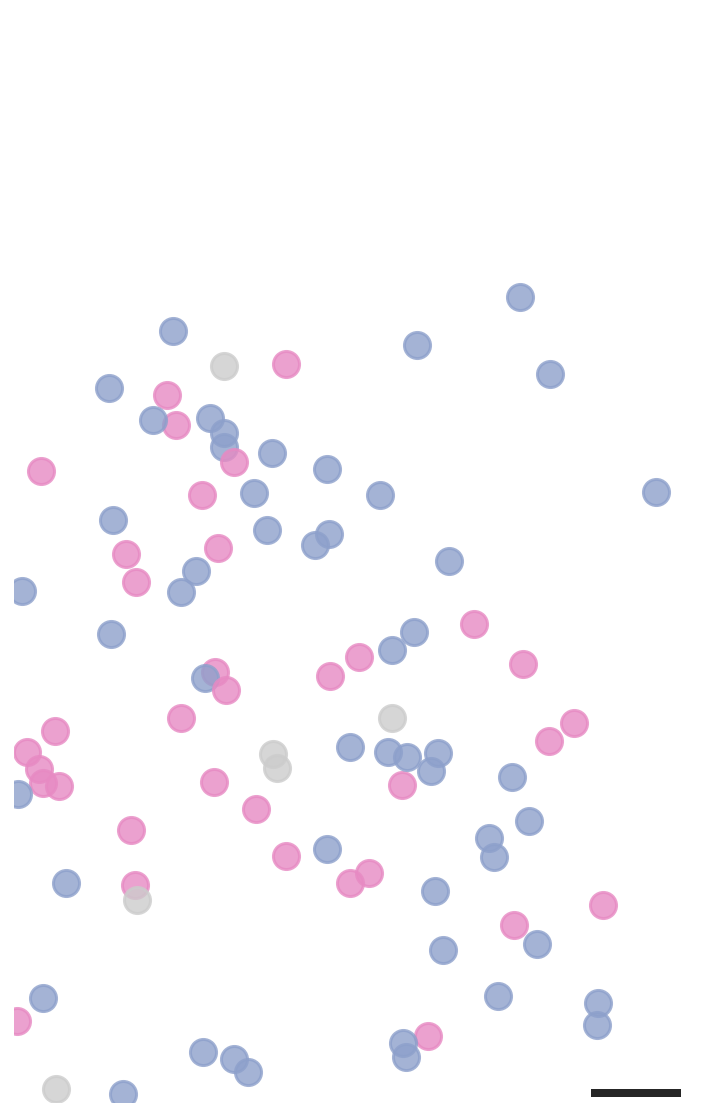

In [39]:
plot = dj_plotter(filtered_cells)
plot.rois(draw_image=False, draw_pixels=False, colors=colors,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

### HD x Border

In [40]:
filtered_hd       = hdcells95 & cells & parameter_dict_cell
filtered_border   = bordercells95 & cells & parameter_dict_cell

In [41]:
filtered_cells = cells & [filtered_hd, filtered_border]

In [42]:
# Add "type" and color info for each cell in each list 
colors = []
for cell in tqdm(filtered_cells, total=len(filtered_cells)):
    if (filtered_hd & cell) and (filtered_border & cell):
        colors.append(np.array([.8,.8,.8]))
    elif filtered_hd & cell:
        colors.append(availabel_colors['hd'])
    elif filtered_border & cell: 
        colors.append(availabel_colors['border']) 

100%|██████████| 81/81 [00:53<00:00,  1.52it/s]


Drawing ROIs:   0%|          | 0/81 [00:00<?, ?it/s]

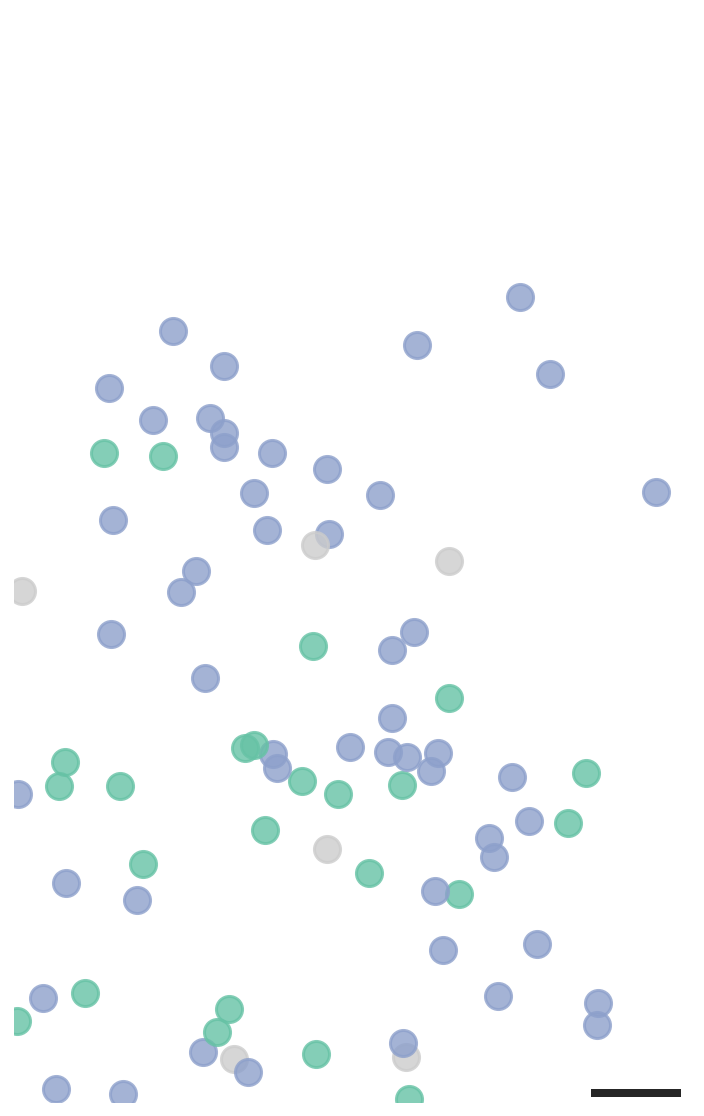

In [43]:
plot = dj_plotter(filtered_cells)
plot.rois(draw_image=False, draw_pixels=False, colors=colors,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

### OV x Border

In [44]:
filtered_ov       = ovcells & cells & parameter_dict_cell
filtered_border   = bordercells95 & cells & parameter_dict_cell

In [45]:
filtered_cells = cells & [filtered_ov, filtered_border]

In [46]:
# Add "type" and color info for each cell in each list 
colors = []
for cell in tqdm(filtered_cells, total=len(filtered_cells)):
    if (filtered_ov & cell) and (filtered_border & cell):
        colors.append(np.array([.8,.8,.8]))
    elif filtered_ov & cell:
        colors.append(availabel_colors['ov'])
    elif filtered_border & cell: 
        colors.append(availabel_colors['border']) 

100%|██████████| 67/67 [00:53<00:00,  1.25it/s]


Drawing ROIs:   0%|          | 0/67 [00:00<?, ?it/s]

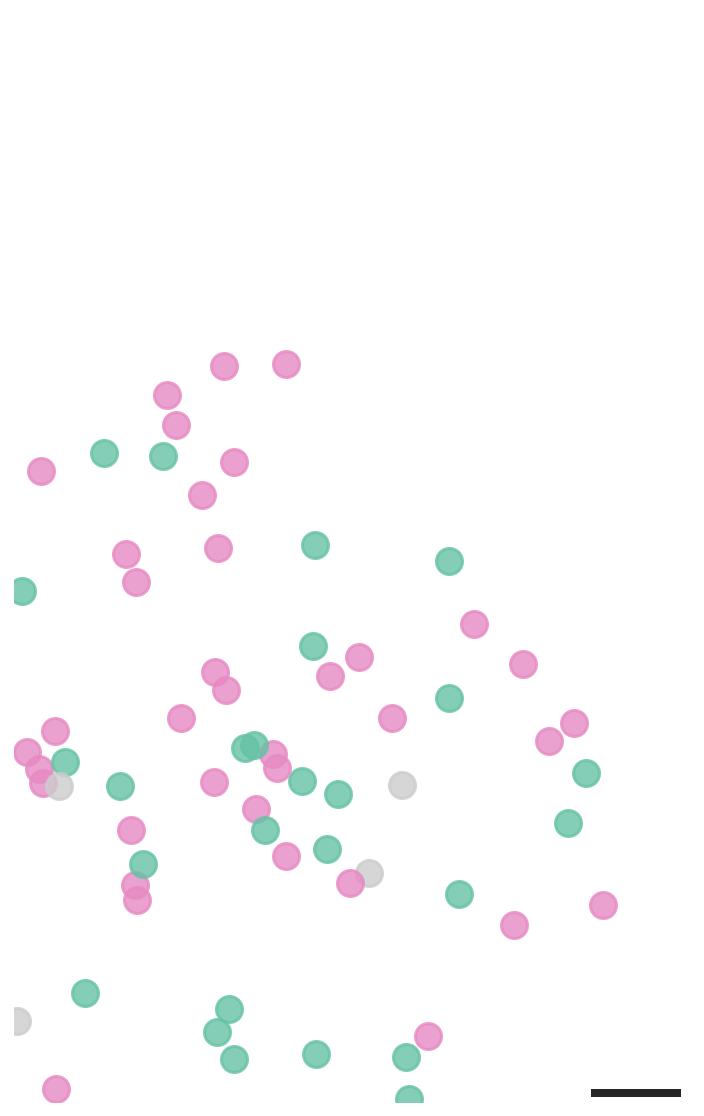

In [47]:
plot = dj_plotter(filtered_cells)
plot.rois(draw_image=False, draw_pixels=False, colors=colors,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

### Border

In [ ]:
# # Add "type" and color info for each cell in each list 

# colors = []
# for cell in cells:
#     if border_cells & cell:
#         colors.append(availabel_colors['border'])
#     elif grid_cells & cell:
#         colors.append(availabel_colors['grid'])
#     elif hd_cells & cell: 
#         colors.append(availabel_colors['hd']) 
#     elif ov_cells & cell: 
#         colors.append(availabel_colors['ov']) 
#     elif (bordercells95 & cell) \
#             or (gridcells95 & cell) \
#             or (hdcells95 & cell) \
#             or (ovcells & cell):
#         colors.append(np.array([.68,.68,.68]))
#     else: 
#         colors.append(np.array([.9,.9,.9]))

In [ ]:
# Conjunctive
border_cells_conj  = bordercells95 & cells & parameter_dict_cell
# Pure
border_cells_pure  = (bordercells95 - gridcells95 - hdcells95 - ovcells) & cells & parameter_dict_cell

# Conjunctive
colors_conj = [availabel_colors['border']]*len(border_cells_conj)
# Pure
colors_pure = [availabel_colors['border']]*len(border_cells_pure)


plot = dj_plotter(cells & border_cells_conj)
plot.rois(draw_image=False, draw_pixels=False, colors=colors_conj,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )
plot = dj_plotter(cells & border_cells_pure)
plot.rois(draw_image=False, draw_pixels=False, colors=colors_pure,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

### Grid

In [ ]:
grid_cells_conj  = gridcells95 & cells & parameter_dict_cell
cells & grid_cells_conj

In [ ]:
# Conjunctive
grid_cells_conj  = gridcells95 & cells & parameter_dict_cell
# Pure
grid_cells_pure  = (gridcells95 - bordercells95 - hdcells95 - ovcells) & cells & parameter_dict_cell

# Conjunctive
colors_conj = [availabel_colors['grid']]*len(grid_cells_conj)
# Pure
colors_pure = [availabel_colors['grid']]*len(grid_cells_pure)


plot = dj_plotter(cells & grid_cells_conj)
plot.rois(draw_image=False, draw_pixels=False, colors=colors_conj,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )
plot = dj_plotter(cells & grid_cells_pure)
plot.rois(draw_image=False, draw_pixels=False, colors=colors_pure,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

### HD

In [ ]:
# Conjunctive
hd_cells_conj  = hdcells95 & cells & parameter_dict_cell
# Pure
hd_cells_pure  = (hdcells95 - bordercells95 - gridcells95 - ovcells) & cells & parameter_dict_cell

# Conjunctive
colors_conj = [availabel_colors['hd']]*len(hd_cells_conj)
# Pure
colors_pure = [availabel_colors['hd']]*len(hd_cells_pure)


plot = dj_plotter(cells & hd_cells_conj)
plot.rois(draw_image=False, draw_pixels=False, colors=colors_conj,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )
plot = dj_plotter(cells & hd_cells_pure)
plot.rois(draw_image=False, draw_pixels=False, colors=colors_pure,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )

### OV

In [ ]:
# Conjunctive
ov_cells_conj  = ovcells & cells & parameter_dict_cell
# Pure
ov_cells_pure  = (ovcells - bordercells95 - gridcells95 - hdcells95)  & cells & parameter_dict_cell

# Conjunctive
colors_conj = [availabel_colors['ov']]*len(ov_cells_conj)
# Pure
colors_pure = [availabel_colors['ov']]*len(ov_cells_pure)


plot = dj_plotter(cells & ov_cells_conj)
plot.rois(draw_image=False, draw_pixels=False, colors=colors_conj,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )
plot = dj_plotter(cells & ov_cells_pure)
plot.rois(draw_image=False, draw_pixels=False, colors=colors_pure,
          dot_size=170,
          draw_centers=True, 
          draw_outlines=False, 
          display_title=False,
          scalebar=50,
         )